In [1]:
import random

from scipy.stats import mode
from copy import deepcopy
from scipy.stats import bernoulli

from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Часть 1: Передача сигнала, один передатчик, нескоррелированные и скоррелированные ансамбли

Допустим, мы передаём сигнал `1`, но в сети возможны помехи, которые мы моделируем как потерю сигнала (`0`).

In [2]:
P = 0.7
LENGTH = 10

ground_truth = np.array([1] * LENGTH)

def generate_predictions(p, length, random_state=None):
    return bernoulli.rvs(p, size=length, random_state=random_state)

def score(preds, ground_truth):
    return np.sum(preds == ground_truth).astype(int) / LENGTH

Как можно передать сигнал:

* Бейслайн — один передатчик.
* Использовать majority vote для трёх или пяти передатчиков.
* То же самое, но с учётом того, что передатчики могут быть скоррелированы.

### Один передатчик

In [3]:
def single_transmitter(r=1000):
    print('Transmission accuracy: {:.3f}'.format(
        np.mean([score(generate_predictions(P, LENGTH),
                       ground_truth) for _ in range(r)])))

In [4]:
interact(single_transmitter, r=IntSlider(min=1, max=100, value=1, step=5))

interactive(children=(IntSlider(value=1, description='r', min=1, step=5), Output()), _dom_classes=('widget-int…

<function __main__.single_transmitter(r=1000)>

### Несколько передатчиков

Majority voting. Используем hard-voting (т.е., без учёта вероятностей, просто большинством голосующих):

$$ŷ = mode(C_1(X),C_2(X),...,C_m(X))$$

Soft-voting:

$$\hat{y} = \arg \max_i \sum^{m}_{j=1} w_j p_{ij}$$

где $w_j$ — вес, который может применён к классификатору `j`.

### Нескоррелированные передатчики

In [5]:
def voting_clf_predictions(preds):
    return mode(preds).mode[0]

In [8]:
ITER = 50
N_CLF = 7

def clf_acc(n_clf):
    return np.mean([
        score(voting_clf_predictions(np.array([
            generate_predictions(P, LENGTH) for _ in range(n_clf)])), ground_truth)
        for _ in range(ITER)])

print('Transmission accuracy: {:.3f}'.format(clf_acc(N_CLF)))

Transmission accuracy: 0.898


In [9]:
n = list(range(1, 18, 2))
acc = list(map(clf_acc, n))

In [10]:
interact(clf_acc, n_clf=IntSlider(min=1, max=25, value=1, step=2));

interactive(children=(IntSlider(value=1, description='n_clf', max=25, min=1, step=2), Output()), _dom_classes=…

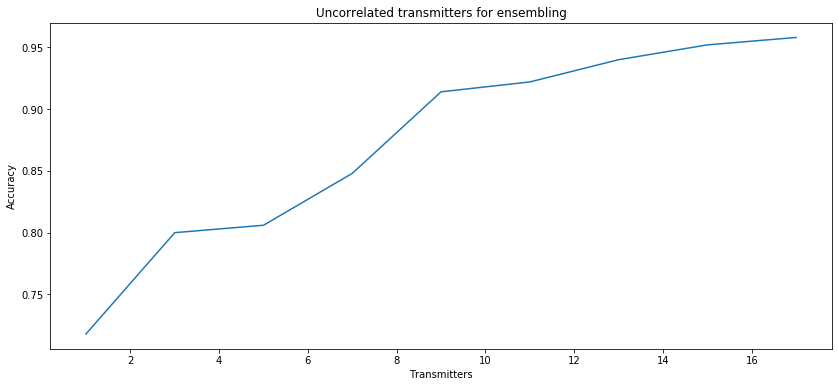

In [11]:
plt.figure(figsize=(14,6))
plt.plot(n, acc)
plt.xlabel('Transmitters')
plt.ylabel('Accuracy')
plt.title('Uncorrelated transmitters for ensembling');

### Скореллированные передатчики

In [17]:
ITER = 1000
N_CLF = 5
DEG_FREEDOM = 5

def clf_acc(n_clf, deg=DEG_FREEDOM):
    preds = []
    for i in range(1, ITER):
        preds_iter = []
        for _ in range(n_clf):
            preds_iter.append(
                generate_predictions(P, LENGTH, random_state=i * np.random.choice(range(deg))))
        preds.append(voting_clf_predictions(preds_iter))
    return np.mean(preds)

print('Transmission accuracy: {:.3f}'.format(clf_acc(N_CLF)))

Transmission accuracy: 0.763


KeyboardInterrupt: 

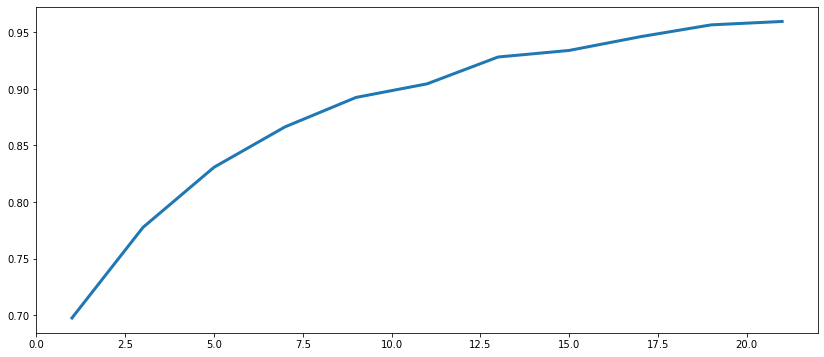

In [15]:
n = list(range(1, 23, 2))
acc = [clf_acc(_n, 99) for _n in n]

plt.figure(figsize=(14,6))
plt.plot(n, acc, label='Mostly uncorrelated', linewidth=3)

for deg in range(1,7):
    n = list(range(1, 23, 2))
    acc = [clf_acc(_n, deg=deg) for _n in n]
    plt.plot(n, acc, label='Degree {}'.format(deg), linewidth=2)

plt.xlabel('Transmitters')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Correlated transmitters for ensembling');

## Часть 2: от дерева решений к RF

In [18]:
from sklearn.datasets import make_classification, make_blobs, make_circles
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
from matplotlib.colors import ListedColormap

In [19]:
make_classification?

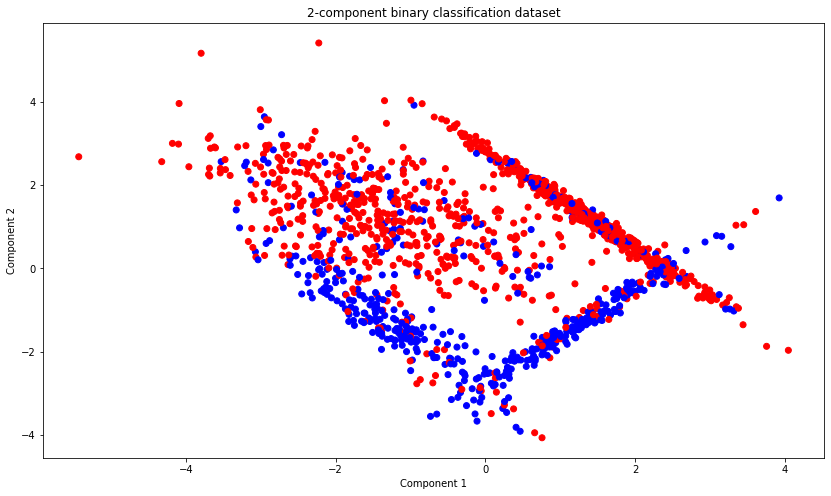

In [20]:
X, y = make_classification(n_samples=1500,
                           n_classes=2,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=2,
                           weights=[.3,.7],
                           flip_y=0.3,
                           class_sep=1.3,
                           random_state=20201030)

plt.figure(figsize=(14,8))
plt.title('2-component binary classification dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
plt.show()

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=20201030)

### Decision Trees

In [22]:
tree_clf_1 = DecisionTreeClassifier(max_depth=20, criterion='gini')

In [23]:
tree_clf_1.fit(X_train, y_train)
y_pred = tree_clf_1.predict_proba(X_val)

In [24]:
roc_auc_score(y_val, y_pred[:,1])

0.6895370879960864

In [25]:
clfs = [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=3),
    DecisionTreeClassifier(max_depth=5),
    DecisionTreeClassifier(max_depth=8),
    DecisionTreeClassifier(max_depth=None),
]

In [26]:
labels = ['DT, depth 1', 'DT, depth 2', 'DT, depth 3', 'DT, depth 5', 'DT, depth 25', 'DT, depth unlim']

In [27]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_six_tree_clfs(clfs, names, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val):

    plt.figure(figsize=(16,10))

    h = .02

    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    for i, (name, clf) in tqdm(enumerate(zip(names, clfs))):
        clf.fit(X_train, y_train)
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)

        ax = plt.subplot(2, len(clfs) / 2, i + 1)
        y_pred = clf.predict_proba(X_val)
        auc = roc_auc_score(y_val, y_pred[:,1])
        plt.title('#{}: {}. ROC AUC: {:.2f}'.format(i, name, auc))
        ax.contourf(xx, yy, Z, cmap='bwr', alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr',
                   edgecolors='k')
        # and testing points
        ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='bwr',
                   edgecolors='k', alpha=0.6)



    plt.tight_layout()
    plt.show()

6it [00:00, 10.90it/s]


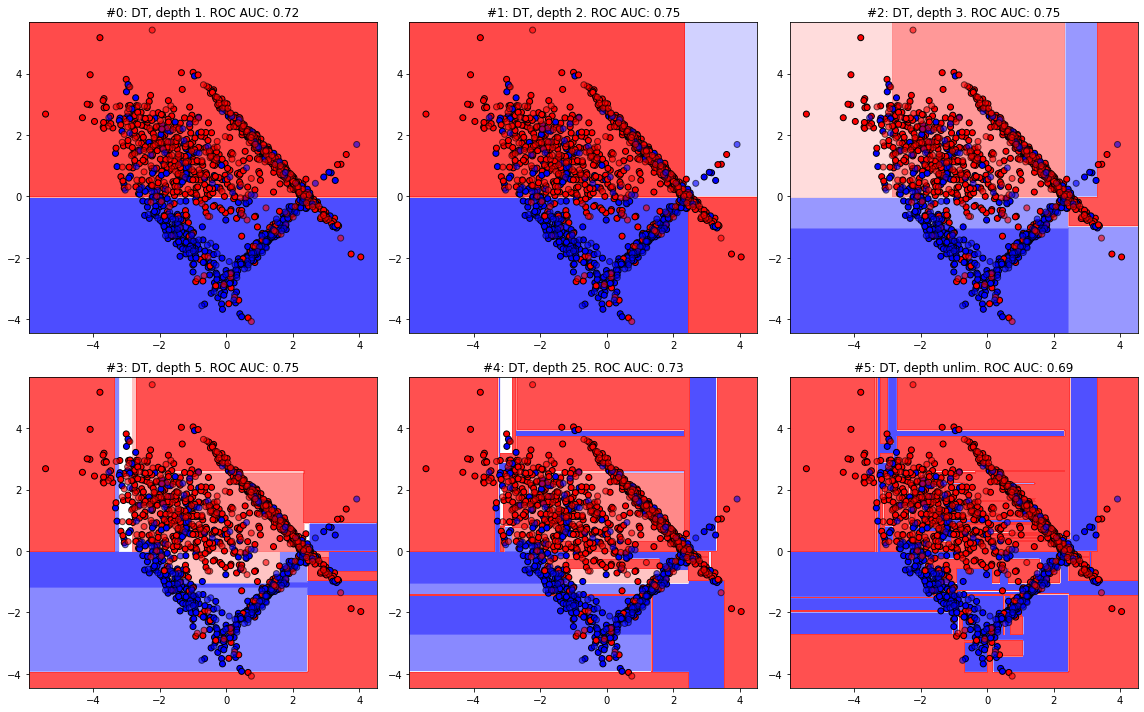

In [28]:
plot_six_tree_clfs(clfs, labels)

### Bootstrap—a subsampling with replacement

In [29]:
from sklearn.ensemble import BaggingClassifier

In [30]:
BaggingClassifier?

In [31]:
clfs = [
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, oob_score=True)
]

names = ['Bootstrap, DT (1, 100)',
         'Bootstrap, DT (2, 100)',
         'Bootstrap, DT (3, 100)',
         'Bootstrap, DT (5, 100)',
         'Bootstrap, DT (8, 100)',
         'Bootstrap, DT (None, 100)']

6it [00:11,  1.89s/it]


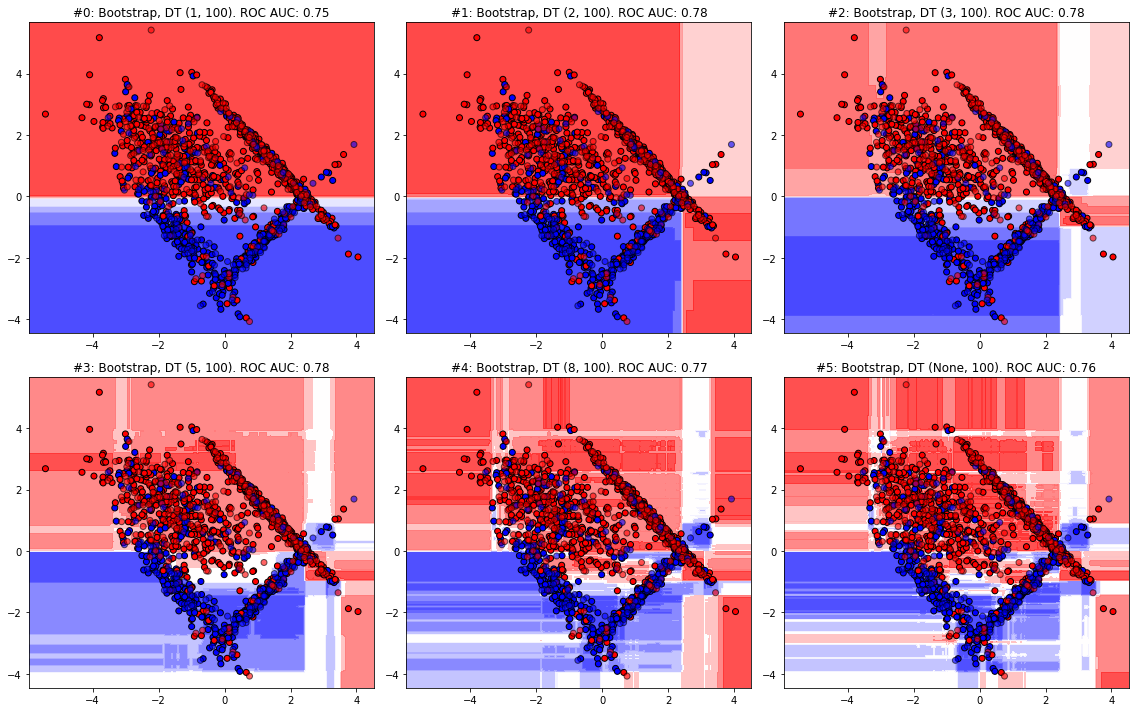

In [32]:
# Bootstrapped samples, no randomization
plot_six_tree_clfs(clfs, names=names)

### Bootstrap with features randomization

In [33]:
# Same estimator building technique, various n_estimators

clfs = [
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), max_features=1, n_estimators=3000)
]

names = ['Bagging, sub, (1, 100)',
         'Bagging, sub, (2, 100)',
         'Bagging, sub, (3, 100)',
         'Bagging, sub, (5, 100)',
         'Bagging, sub, (None, 100)',
         'Bagging, sub, (None, 3000)']

6it [01:11, 12.00s/it]


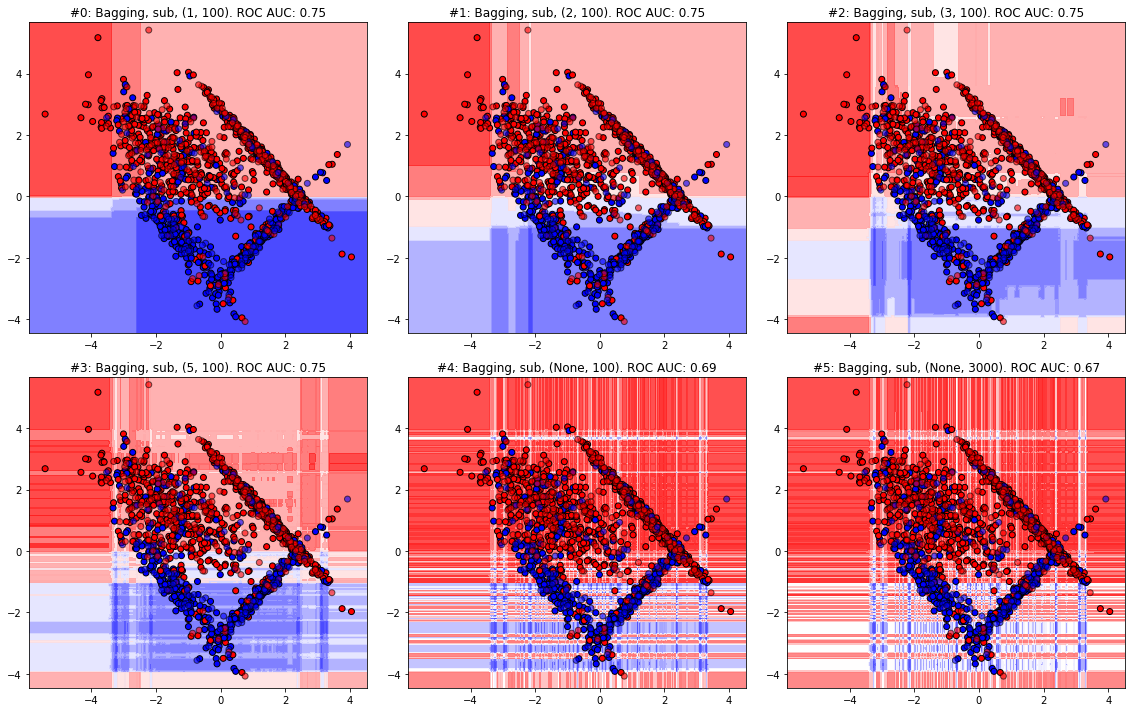

In [34]:
plot_six_tree_clfs(clfs, names=names)

### Bootstrap with feature randomization on each split

In [37]:
clfs = [
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8, max_features=1), n_estimators=200),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None, max_features=1), n_estimators=200)
]

names = ['Bagging, sub/each_split, (1, 100)',
         'Bagging, sub/each_split, (2, 100)',
         'Bagging, sub/each_split, (3, 100)',
         'Bagging, sub/each_split, (5, 100)',
         'Bagging, sub/each_split, (8, 1000)',
         'Bagging, sub/each_split, (None, 1000)']

6it [00:14,  2.45s/it]


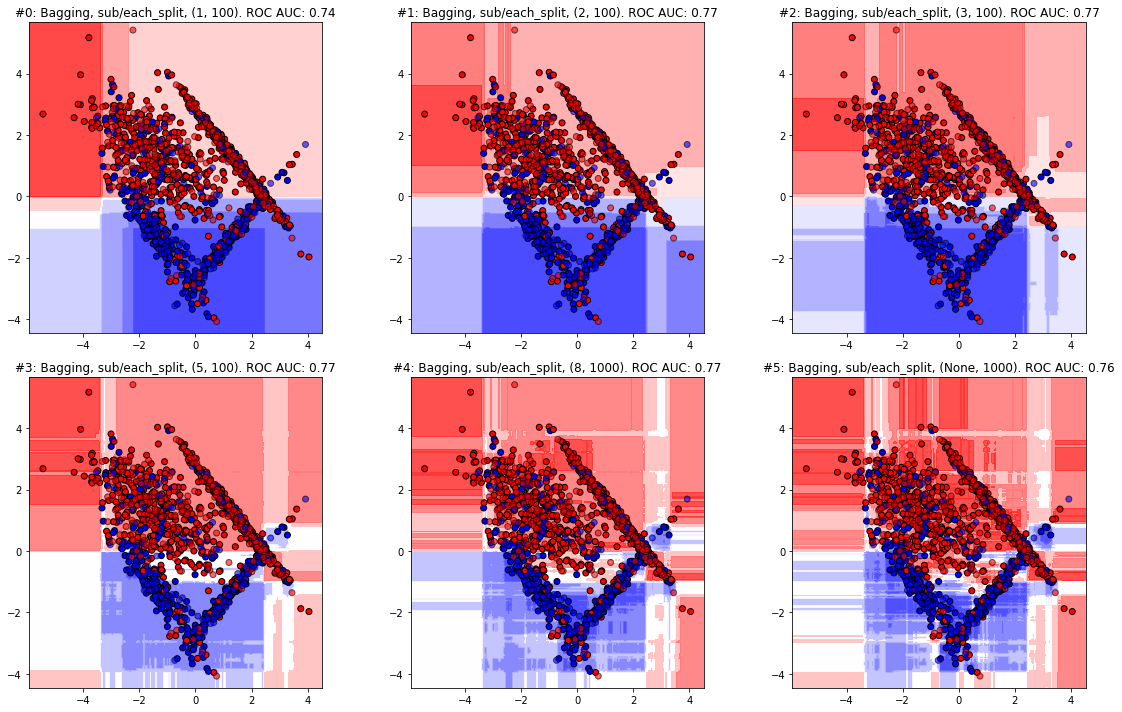

In [38]:
plot_six_tree_clfs(clfs, names)

### Same as above, only for depth=5 (optimal)

In [39]:
clfs = [
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=10),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=50),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=200),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=200),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=200)
]

names = ['Bagging, sub/each_split, (5, 10)',
         'Bagging, sub/each_split, (5, 50)',
         'Bagging, sub/each_split, (5, 100)',
         'Bagging, sub/each_split, (5, 200)',
         'Bagging, sub/each_split, (5, 200)',
         'Bagging, sub/each_split, (5, 200)']

6it [00:14,  2.41s/it]


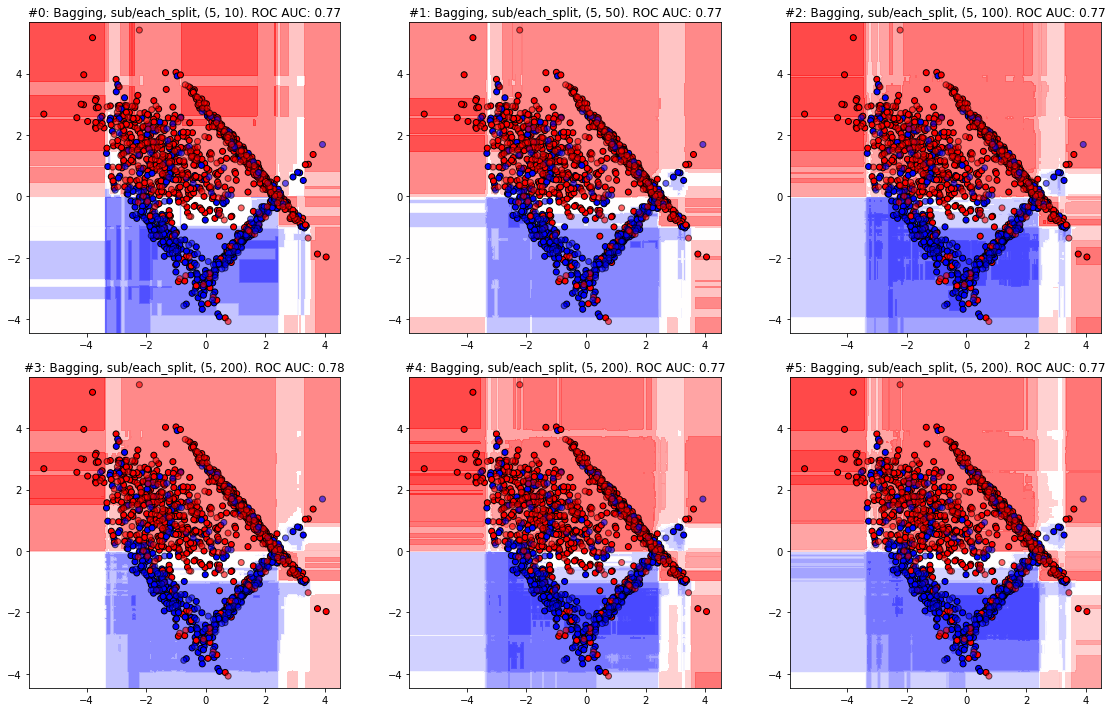

In [40]:
plot_six_tree_clfs(clfs, names)

### Сравните с Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
# Same estimator building technique, various n_estimators

clfs = [
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=50, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=200, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=200, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=200, max_features=1),
]

names = ['RF, (5, 10)',
         'RF, (5, 50)',
         'RF, (5, 100)',
         'RF, (5, 200)',
         'RF, (5, 200)',
         'RF, (5, 200)']

6it [00:12,  2.07s/it]


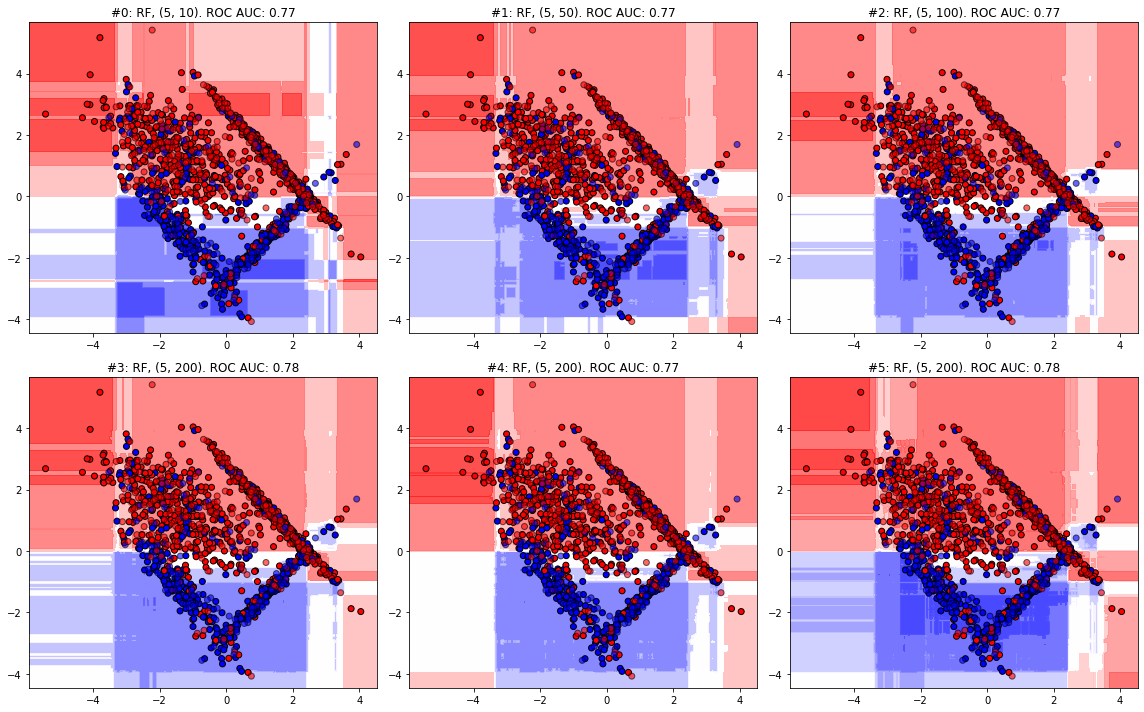

In [43]:
plot_six_tree_clfs(clfs, names)

----

## Данные об оттоке из игры

In [44]:
import pandas as pd

dfx = pd.read_csv('data/x_train.csv', sep=';')
dfy = pd.read_csv('data/y_train.csv', names=['target'])

In [45]:
X = dfx.values
y = dfy.values.flatten()

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [47]:
dfx.head().T

0             1         2  \
maxPlayerLevel                      3.900000e+01  2.100000e+01       5.0   
numberOfAttemptedLevels             1.000000e+01  2.200000e+01       6.0   
attemptsOnTheHighestLevel           3.000000e+00  1.900000e+01       1.0   
totalNumOfAttempts                  1.700000e+01  5.500000e+01       6.0   
averageNumOfTurnsPerCompletedLevel  2.444444e+01  1.704545e+01       8.4   
doReturnOnLowerLevels               1.000000e+00  1.000000e+00       0.0   
numberOfBoostersUsed                5.000000e+00  6.000000e+00       1.0   
fractionOfUsefullBoosters           4.000000e-01  3.333333e-01       1.0   
totalScore                          2.650000e+06  5.614000e+06  857000.0   
totalBonusScore                     1.375000e+03  3.825000e+03    1150.0   
totalStarsCount                     2.100000e+01  5.100000e+01      14.0   
numberOfDaysActuallyPlayed          2.000000e+00  4.000000e+00       1.0   

                                           3         4  
maxPlayerLevel                          21.0       4.0  
numberOfAttemptedLevels                  2.0       5.0  
attemptsOnTheHighestLevel                5.0       1.0  
totalNumOfAttempts                       6.0       5.0  
averageNumOfTurnsPerCompletedLevel      19.0       9.6  
doReturnOnLowerLevels                    0.0       0.0  
numberOfBoostersUsed                     1.0       1.0  
fractionOfUsefullBoosters                0.0       1.0  
totalScore                          120000.0  857000.0  
totalBonusScore                          0.0    1075.0  
totalStarsCount                          1.0      12.0  
numberOfDaysActuallyPlayed               1.0       1.0

In [48]:
dfy.head()

target
0       0
1       1
2       1
3       1
4       0

### Качество на одном дереве

In [49]:
cv = StratifiedKFold(n_splits=4, random_state=20201030)
scoring = 'roc_auc'

In [50]:
model = DecisionTreeClassifier()

In [51]:
depths = range(1, 10)
_, tree_test_scores = validation_curve(model, X, y, 
                                       param_name='max_depth',
                                       param_range=depths, 
                                       scoring=scoring, cv=cv, n_jobs=-1)

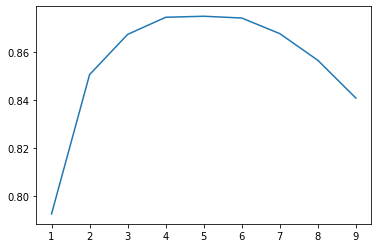

In [52]:
plt.plot(depths, tree_test_scores.mean(axis=1))

### Бэггинг над деревьями

In [53]:
from sklearn.ensemble import BaggingClassifier

In [54]:
model = BaggingClassifier(DecisionTreeClassifier(), 
                          n_estimators=50, random_state=20201030)

In [55]:
_, bag_test_scores = validation_curve(model, X, y, 
                                      param_name='base_estimator__max_depth', 
                                      param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=-1)

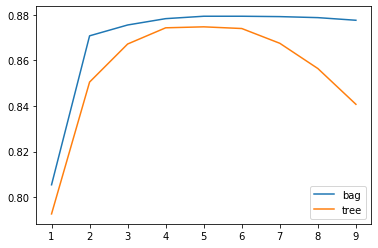

In [56]:
plt.plot(depths, bag_test_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_test_scores.mean(axis=1), label='tree')
plt.legend()

### Случайный лес

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
model = RandomForestClassifier(random_state=20201030, n_estimators=50, 
                               n_jobs=-1)

In [59]:
_, forest_test_scores = validation_curve(model, X, y, 
                                         param_name='max_depth', 
                                         param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=1)

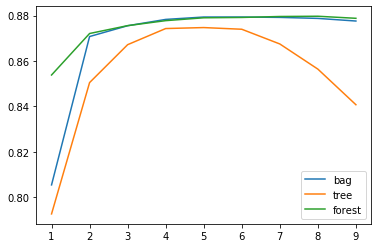

In [60]:
plt.plot(depths, bag_test_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_test_scores.mean(axis=1), label='tree')
plt.plot(depths, forest_test_scores.mean(axis=1), label='forest')
plt.legend()

## Часть 3: Бустинг

Boosting, в отличие от bagging'а - это **последовательный** способ построения композиции моделей.

Мы постоянно работаем с одним и тем же набором данных, **но** на каждом шаге строим новую базовую модель, которая учитывает ошибки предыдущей модели. По большому счету, бустинг-алгоритмы отличаются лишь тем, как в них заложен учет этих самых ошибок.

Например в методе **AdaBoost** каждому объекту присваивается вес, который изменяется в зависимости от того, ошиблась ли на нем очередная композиция базовых алгоритмов или нет. Так же веса имеются и у самих базовых моделей, которые штрафуют их за плохие предсказания. Для задачи классификации этот процесс можно проиллюстрировать следующим образом:


<center><img src='ensembles/img/adaboost.png' width='650'></center>

### Демо

In [61]:
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


def ada_demo(n_est=1):

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,), n_estimators=n_est, learning_rate=0.1)
    ada.fit(X_moons, y_moons)
    

    plt.figure(figsize=(7,5))

    xx1, xx2 = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                           np.arange(-1, 1.5, 0.1))

    y_hat = ada.predict(np.c_[xx1.ravel(), xx2.ravel()])
    
    y_hat = y_hat.reshape(xx1.shape)

    plt.title('iteration = %d' % n_est )
    plt.contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
    
    plt.show()

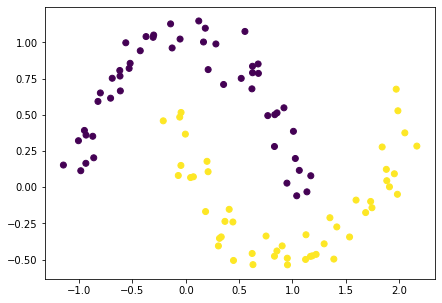

In [62]:
X_moons, y_moons = make_moons(noise=0.1)
plt.figure(figsize=(7,5))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

In [63]:
interact(ada_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), Output()), _dom_classes=('widge…

<function __main__.ada_demo(n_est=1)>

### Градиентный бустинг

По своей структуре метод похож на алгоритм градиентного спуска - отсюда и такое название.

<center><img src='ensembles/img/golf-MSE.png' width=600></center>

<center><img src='ensembles/img/golf-table.svg' width=700></center>

### Простое демо

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def rf_demo(n_est=1, max_depth=1):
    
    np.random.seed(123)
    X = np.random.uniform(-10, 10, 500)

    y = np.sin(X) / X + np.random.normal(0, .1, 500)
    plt.scatter(X, y)
    

    rf = RandomForestRegressor(n_estimators=n_est, max_depth=max_depth)
    
    rf.fit(X.reshape(-1, 1), y)
    
    x_range = np.linspace(X.min(), X.max(), 500).reshape((-1,1))

    y_hat = rf.predict(x_range)
    plt.plot(x_range, y_hat, c='r')
    
    plt.title('Estimators %d' % n_est)
    plt.xlabel('x')
    plt.xlabel('y')
    plt.ylim((-0.5, 1.3))
    plt.xlim(-11,11)
    
    plt.show()

def grad_demo(n_est=1):
    
    np.random.seed(123)
    X = np.random.uniform(-10, 10, 500)

    y = np.sin(X)/X + np.random.normal(0, .1, 500)
    plt.scatter(X, y)
    
    gbr = GradientBoostingRegressor(n_estimators=n_est, learning_rate=0.15)
    gbr_full = GradientBoostingRegressor(n_estimators=200, learning_rate=0.15)
    gbr.fit(X.reshape(-1,1), y)
    gbr_full.fit(X.reshape(-1,1), y)
    
    x_range = np.linspace(X.min(), X.max(), 100).reshape((-1,1))

    for y_hat in gbr.staged_predict(x_range):
        plt.plot(x_range, y_hat, c='g')

    y_hat = gbr_full.predict(x_range)
    
    plt.title('Estimators %d' % n_est)
    plt.plot(x_range, y_hat, c='r')
    plt.xlabel('x')
    plt.xlabel('y')
    plt.ylim((-0.5, 1.3))
    plt.xlim(-11,11)
    
    plt.show()

In [65]:
interact(rf_demo, n_est=IntSlider(min=1, max=150, value=1, step=1),
                  max_depth=IntSlider(min=1, max=10, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), IntSlider(value=1, description=…

<function __main__.rf_demo(n_est=1, max_depth=1)>

In [66]:
interact(grad_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), Output()), _dom_classes=('widge…

<function __main__.grad_demo(n_est=1)>

### Попробуем более сложный датасет

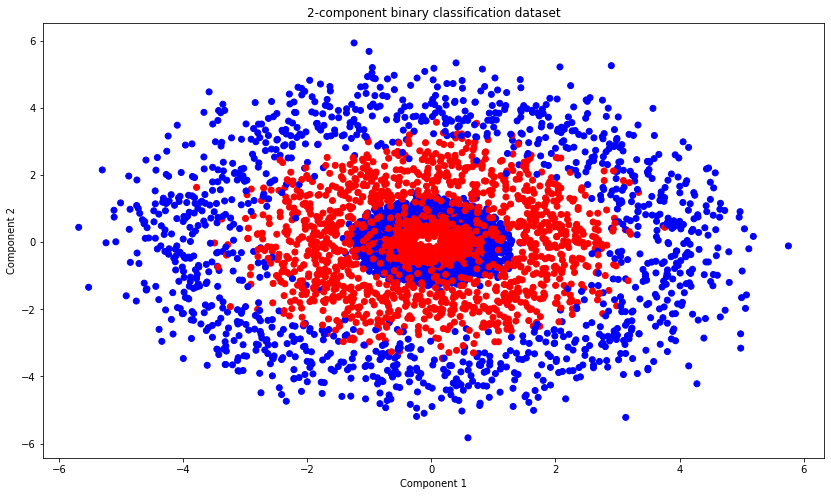

In [67]:
X, y = make_circles(n_samples=2500, noise=0.16, factor=0.55, random_state=20201030)
X2, y2 = make_circles(n_samples=2500, noise=0.16, factor=0.5, random_state=20201030)

X2 = X2 * 4

X2 = np.vstack([X, X2])
y2 = np.hstack([y, y2])
plt.figure(figsize=(14,8))
plt.title('2-component binary classification dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap='bwr')
plt.show()

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.25, random_state=20201030)

In [69]:
# Random Forest on the new dataset

clfs = [
    RandomForestClassifier(max_depth=2, max_features=1, n_estimators=1),
    RandomForestClassifier(max_depth=2, max_features=1, n_estimators=5),
    RandomForestClassifier(max_depth=2, max_features=1, n_estimators=10),
    RandomForestClassifier(max_depth=3, max_features=1, n_estimators=30),
    RandomForestClassifier(max_depth=3, max_features=1, n_estimators=90),
    RandomForestClassifier(max_depth=3, max_features=1, n_estimators=400),
]

names = ['RF, (2, 1)',
         'RF, (2, 5)',
         'RF, (2, 10)',
         'RF, (3, 30)',
         'RF, (3, 90)',
         'RF, (3, 400)']

6it [00:12,  2.03s/it]


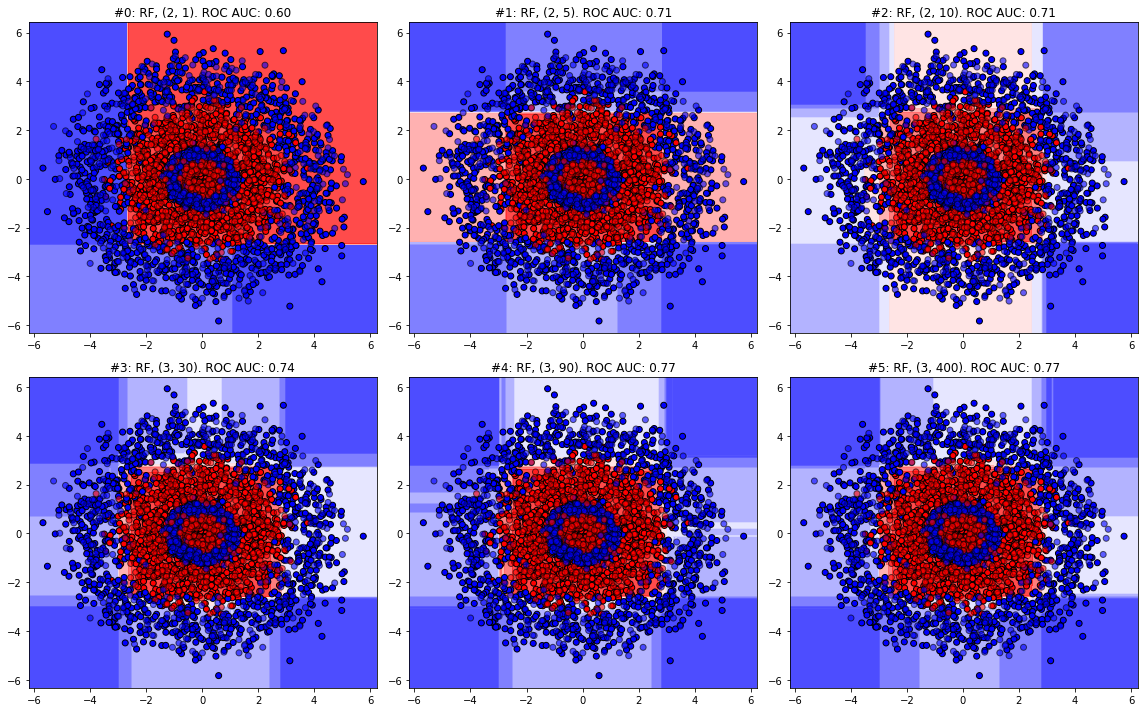

In [70]:
plot_six_tree_clfs(clfs, names, X_train, X_val, y_train, y_val)

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

In [72]:
# Same estimator building technique, various n_estimators

clfs = [
    GradientBoostingClassifier(n_estimators=1, max_depth=2),
    GradientBoostingClassifier(n_estimators=5, max_depth=2, subsample=0.5),
    GradientBoostingClassifier(n_estimators=10, max_depth=2, subsample=0.5),
    GradientBoostingClassifier(n_estimators=30, max_depth=3, subsample=0.5),
    GradientBoostingClassifier(n_estimators=90, max_depth=3, subsample=0.5),
    GradientBoostingClassifier(n_estimators=400, max_depth=3, subsample=0.5),
]

names = ['GBC, (2, 1)',
         'GBC, (2, 5)',
         'GBC, (2, 10)',
         'GBC, (3, 30)',
         'GBC, (3, 90)',
         'GBC, (3, 400)']

6it [00:03,  1.62it/s]


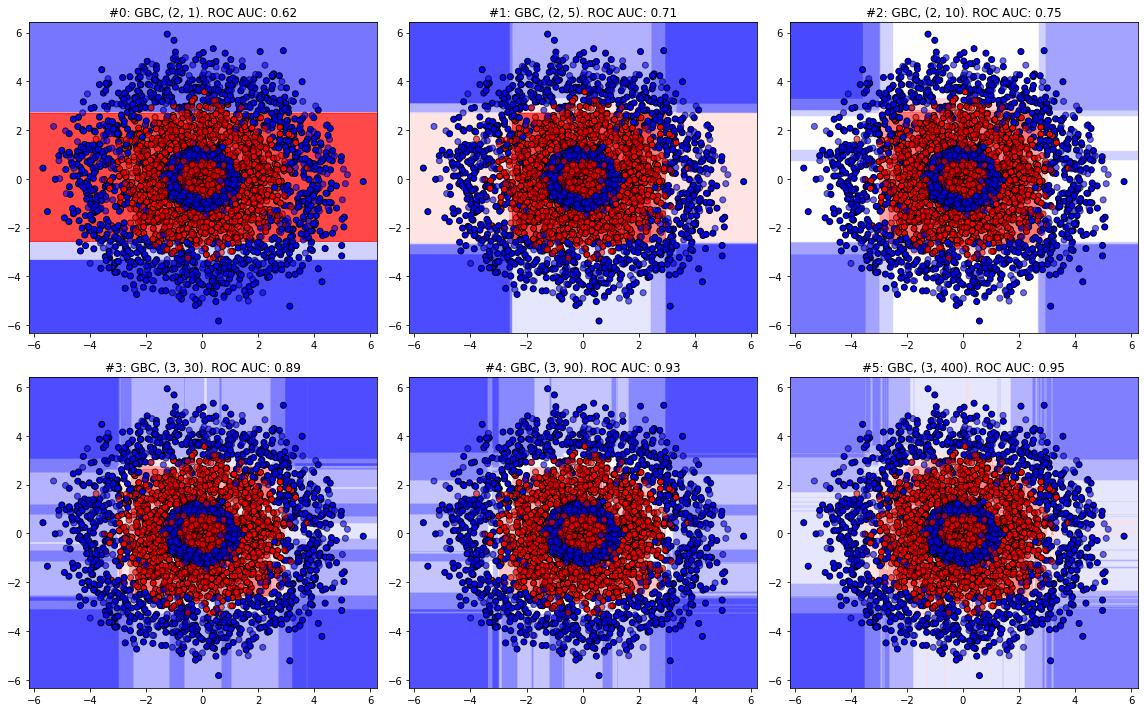

In [73]:
plot_six_tree_clfs(clfs, names, X_train, X_val, y_train, y_val)

In [75]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPClassifier as MLP

clfs = [
    MLPClassifier(hidden_layer_sizes=(10)),
    MLPClassifier(hidden_layer_sizes=(10, 5)),
    MLPClassifier(hidden_layer_sizes=(100, 50)),
    MLPClassifier(hidden_layer_sizes=(200, 100)),
    MLPClassifier(hidden_layer_sizes=(200, 100, 50)),
    MLPClassifier(hidden_layer_sizes=(300, 200, 100)),
]

names = ['MLP, 10',
         'MLP, 30',
         'MLP, 50',
         'MLP, 100',
         'MLP, 150',
         'MLP, 300',]

1it [00:01,  1.21s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
6it [00:34,  5.74s/it]


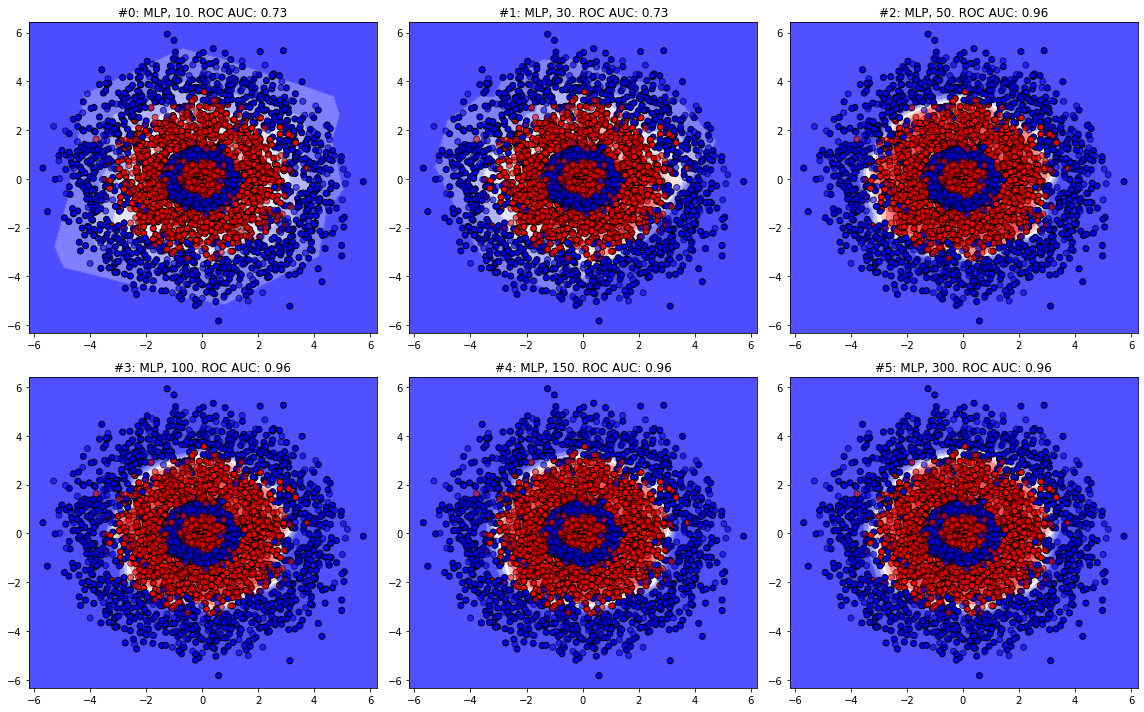

In [76]:
plot_six_tree_clfs(clfs, names, X_train, X_val, y_train, y_val)

In [77]:
from sklearn.svm import SVC

А теперь сравним множество алгоритмов с VotingClassifier и стекингом "из коробки".

Вам понадобится библиотека mlxtend.
Рекомендую её _особенно_ для построения наглядных визуализаций (по типу тех, что я показывал на занятии выше).
- Сама библиотека: http://rasbt.github.io/mlxtend/
- Ссылка на user guide: http://rasbt.github.io/mlxtend/USER_GUIDE_INDEX/

In [78]:
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import cross_val_score

In [79]:
from sklearn.ensemble import VotingClassifier

In [80]:
gb = SVC(C=1.5, kernel='rbf', probability=True)
clf1 = MLP(hidden_layer_sizes=(100, 50))
clf2 = MLP(hidden_layer_sizes=(200, 100, 50))
clf3 = GradientBoostingClassifier(n_estimators=30, max_depth=3, subsample=0.5)
svm = SVC(C=1.5, kernel='rbf', probability=True)
eclf = VotingClassifier([('nn', clf1), ('nn2', clf2), ('gbdt', clf3)], voting='soft')
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, svm], 
                            meta_classifier=gb)

clfs = [clf1, clf2, clf3, svm, eclf, sclf]

In [81]:
names = ['MLP, 100-50',
         'MLP, 200-100-50',
         'GBDT, 30',
         'SVC, RBF',
         'ECLF',
         'SCLF']

3it [00:13,  4.53s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
5it [00:36,  7.94s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.",

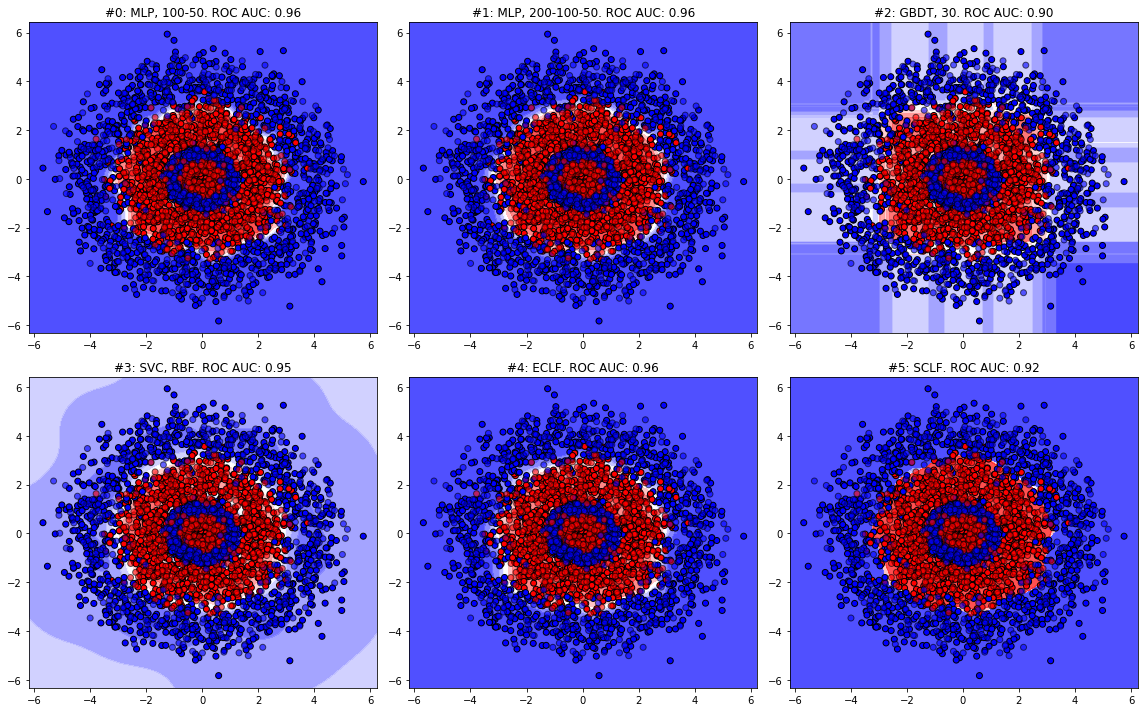

In [82]:
plot_six_tree_clfs(clfs, names, X_train, X_val, y_train, y_val)

In [83]:
for clf, label in zip([clf1, clf2, clf3, eclf, sclf], ['NN', 'NN', 'GBDT', 'Vote', 'Stack']):
    sc = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print('CV: {} for {}'.format(sc.mean(), label))

CV: 0.9132021306032098 for NN
CV: 0.9111979647051589 for NN
CV: 0.8983937849720224 for GBDT
CV: 0.9140024518846461 for Vote


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

CV: 0.9119973252167498 for Stack


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
